[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [72]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [74]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [75]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching land mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about elephants. But what others should I learn about?", name="Keshav"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching land mammals?
================================ Human Message =================================
Name: Keshav

Yes, I know about elephants. But what others should I learn about?


Recall we can pass them to a chat model.

In [76]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to elephants, there are several other fascinating land mammals worth learning about:\n\n1. **Lions** - Known as the "king of the jungle," lions are social big cats that live in prides and are primarily found in Africa.\n\n2. **Tigers** - These are the largest wild cats and have distinctive stripes. They are native to Asia.\n\n3. **Giraffes** - The tallest land animals, giraffes are known for their long necks and legs and are native to African savannas.\n\n4. **Rhinoceroses** - Large, thick-skinned herbivores with one or two horns on their snouts, they are found in Africa and Asia.\n\n5. **Wolves** - Social animals that live in packs, wolves are skilled hunters and are found across much of the Northern Hemisphere.\n\n6. **Bison** - Large herbivores that once roamed in massive herds across North America and Europe.\n\n7. **Bears** - Found in various parts of the world, including North America, Europe, and Asia; notable species include grizzly bears and pola

In [77]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo")
llm.invoke(messages)

AIMessage(content='There are many different types of land mammals aside from elephants that you can research. Some examples include lions, tigers, giraffes, zebras, rhinoceroses, hippopotamuses, cheetahs, wolves, bears, and many more. Each of these animals has unique characteristics and behaviors that make them fascinating to study.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 41, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CTmiHE25gtDj4lxoQyc2YGWAh8dnR', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--7959c412-1139-4883-a082-6d2647d9ee24-0', usage_metadata={'input_tokens': 41, 'output_tokens': 7

We can run our chat model in a simple graph with `MessagesState`.

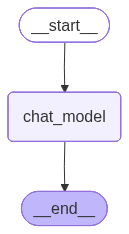

In [78]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching land mammals?
================================ Human Message =================================
Name: Keshav

Yes, I know about elephants. But what others should I learn about?
================================== Ai Message ==================================

There are many interesting land mammals that you could research, depending on your interests. Some popular ones include lions, tigers, giraffes, zebras, rhinoceroses, hippos, bears, wolves, and cheetahs. You could also explore lesser-known species like pangolins, okapis, maned wolves, and quokkas. Each species has unique characteristics, behaviors, and features that make them fascinating to study.


## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

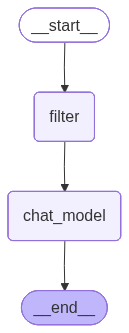

In [80]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [81]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Keshav", id="2"))
messages.append(AIMessage("So you said you were researching land mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about elephants. But what others should I learn about?", name="Keshav", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching land mammals?
================================ Human Message =================================
Name: Keshav

Yes, I know about elephants. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating land mammals to learn about! Here are some suggestions:

1. Lions - known as the "King of the Jungle," lions are majestic big cats that live in prides and are apex predators.
2. Giraffes - the tallest land mammal, with long necks and legs, giraffes are known for their unique appearance and gentle nature.
3. Bears - ranging from polar bears in the Arctic to grizzly bears in North America, bears are powerful omnivores that are both feared and revered.
4. Cheetahs - the fastest land animal, cheetahs are sleek, graceful predators that can reach speeds of up to 60 miles per hour.
5. Rhino

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

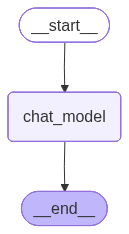

In [82]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [83]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about tigers!", name="Keshav"))

In [84]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Keshav

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching land mammals?
================================ Human Message =================================
Name: Keshav

Yes, I know about elephants. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating land mammals to learn about! Here are some suggestions:

1. Lions - known as the "King of the Jungle," lions are majestic big cats that live in prides and are apex predators.
2. Giraffes - the tallest land mammal, with long necks and legs, giraffes are known for their unique appearance and gentle nature.
3. Bears - ranging from polar bears in the Arctic to grizzly bears in North America, bear

In [85]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Keshav

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching land mammals?
================================ Human Message =================================
Name: Keshav

Yes, I know about elephants. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating land mammals to learn about! Here are some suggestions:

1. Lions - known as the "King of the Jungle," lions are majestic big cats that live in prides and are apex predators.
2. Giraffes - the tallest land mammal, with long necks and legs, giraffes are known for their unique appearance and gentle nature.
3. Bears - ranging from polar bears in the Arctic to grizzly bears in North America, bear

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

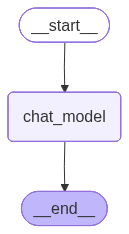

In [86]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [87]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Tigers are found!", name="Keshav"))

In [88]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Tigers are found!', additional_kwargs={}, response_metadata={}, name='Keshav')]

In [89]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r